In [13]:
import pandas as pd
import numpy as np
import os
import cv2

from metods import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import image

from skimage.io import imread

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
PADDING = 40

models_folder = "models\\"

modelName = models_folder + "LungIdentifierModel2.h5"

TRAINING_MODE = True
KAGGLE_MODE = False

healty_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty\\"
healty_mask_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty Mask\\"
healty_segmented_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Healty Segmented\\"

pneu_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax\\"
pneu_mask_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax Mask\\"
pneu_segmented_path = "C:\\Users\\ugur_\\Python Projects\\LungClassifier\\NIH Data\\Pneumothorax Segmented\\"

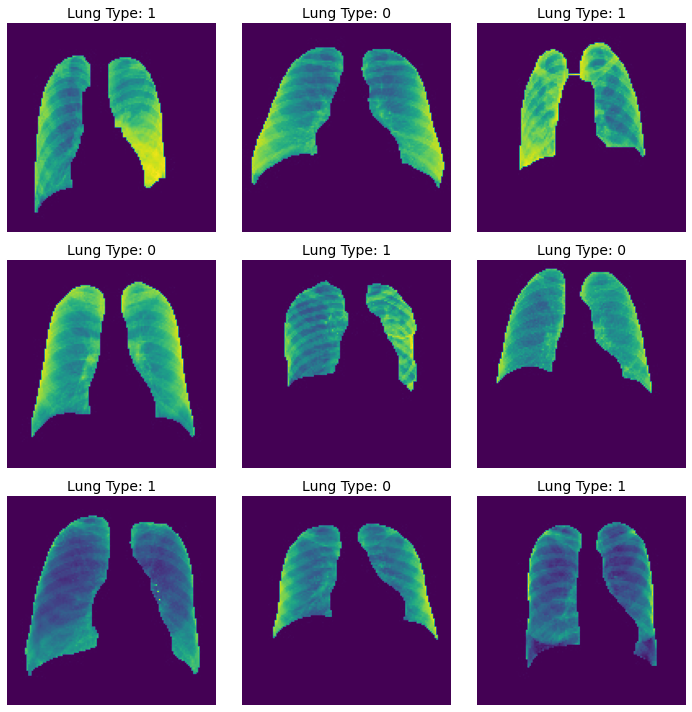

In [3]:
test_id_list = [
'NIH Data\\Healty Segmented\\segment_00000037_000.png',
'NIH Data\\Pneumothorax Segmented\\segment_00000832_004.png',
'NIH Data\\Healty Segmented\\segment_00000070_000.png',
'NIH Data\\Pneumothorax Segmented\\segment_00001376_008.png',
'NIH Data\\Healty Segmented\\segment_00000190_000.png',
'NIH Data\\Pneumothorax Segmented\\segment_00001951_013.png',
'NIH Data\\Healty Segmented\\segment_00000242_001.png',
'NIH Data\\Pneumothorax Segmented\\segment_00002316_006.png',
'NIH Data\\Healty Segmented\\segment_00000272_002.png',
'NIH Data\\Pneumothorax Segmented\\segment_00002492_002.png']

types = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

X_test = np.zeros((len(test_id_list), IMG_HEIGHT, IMG_WIDTH))

for i, img_id in enumerate(test_id_list):
    img = readImages(img_id)
    X_test[i] = img

plt.figure(figsize=(10,10))
plt.axis('Off')

for i in range(1, 10):
    plt.subplot(3,3,i)
    test_image = X_test[i, :, :]
    plt.imshow(test_image, cmap=plt.cm.bone)
    plt.title(f'Lung Type: {types[i]}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
healty_segmented_images = os.listdir(healty_segmented_path)
pneu_segmented_images = os.listdir(pneu_segmented_path)

X_train = np.zeros((len(healty_segmented_images) + len(pneu_segmented_images), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_train = np.zeros((len(healty_segmented_images) + len(pneu_segmented_images)), dtype=np.bool)

for i, img_id in enumerate(healty_segmented_images):
    file_name = healty_segmented_path + img_id

    img = readImages(file_name, is_gray=0)
    
    X_train[i] = img
    Y_train[i] = 0

for i, img_id in enumerate(pneu_segmented_images):
    file_name = pneu_segmented_path + img_id
    
    img = readImages(file_name, is_gray=0)
    
    X_train[len(healty_segmented_images) + i] = img
    Y_train[len(healty_segmented_images) + i] = 1

X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_train = X_train.reshape(-1, 128, 128, 3)

Y_train = to_categorical(Y_train)

print(X_train.shape)
print(Y_train.shape)

(3630, 128, 128, 3)
(3630, 2)


In [21]:
#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=8)

In [22]:
from tensorflow.keras.applications import VGG16

input_layer=layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model_vgg16=VGG16(weights='imagenet', input_tensor=input_layer, include_top=False)

last_layer=model_vgg16.output 

flatten=layers.Flatten()(last_layer) 

output_layer=layers.Dense(2, activation='softmax')(flatten)

model=models.Model(inputs=input_layer, outputs=output_layer)

for layer in model.layers[:-1]:
    layer.trainable=False

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

Epoch 1/200
182/182 [==============================] - 4s 18ms/step - loss: 0.6386 - accuracy: 0.6666 - val_loss: 0.4657 - val_accuracy: 0.7865

Epoch 00001: val_accuracy improved from -inf to 0.78650, saving model to models\LungIdentifierModel2.h5
Epoch 2/200
182/182 [==============================] - 3s 17ms/step - loss: 0.4334 - accuracy: 0.8088 - val_loss: 0.5257 - val_accuracy: 0.7700

Epoch 00002: val_accuracy did not improve from 0.78650
Epoch 3/200
182/182 [==============================] - 3s 17ms/step - loss: 0.4237 - accuracy: 0.8015 - val_loss: 0.4721 - val_accuracy: 0.7782

Epoch 00003: val_accuracy did not improve from 0.78650
Epoch 4/200
182/182 [==============================] - 3s 17ms/step - loss: 0.3992 - accuracy: 0.8231 - val_loss: 0.5206 - val_accuracy: 0.7617

Epoch 00004: val_accuracy did not improve from 0.78650

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/200
182/182 [==============================] - 3s 17ms/step - 

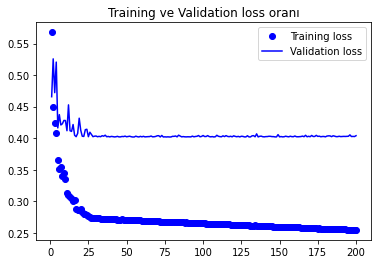

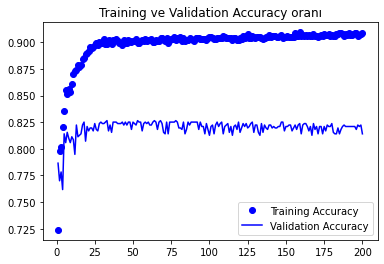

<Figure size 432x288 with 0 Axes>

In [23]:
if TRAINING_MODE:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    earlystopper = EarlyStopping(patience=15, verbose=1)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    checkpoint = ModelCheckpoint(modelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, learning_rate_reduction]

    history = model.fit(X_train/255.0, Y_train, validation_data=(X_test/255.0, Y_test), batch_size=16, epochs=200, callbacks=callbacks_list, shuffle=True)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training ve Validation loss oranı')
    plt.legend()
    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training ve Validation Accuracy oranı')
    plt.legend()
    plt.figure()
else:
    model = load_model(modelName)

In [16]:
model = load_model(modelName)

df_test = pd.DataFrame()

Y_test_normal = np.argmax(Y_test, axis=-1)

print(Y_test_normal.shape)

df_test['type'] = Y_test_normal

df_test = df_test.reset_index(drop=True)

df_test.head(10)

def fixImages(folder_name):
    for img_name in os.listdir(folder_name):
        try:
            readImages(folder_name + img_name)
        except Exception as ex:
            os.remove(folder_name + img_name)

(726,)


In [17]:
preds = np.argmax(model.predict(X_test/255.0), axis=-1)

df_test['preds'] = np.round(preds)
df_test['preds'] = df_test['preds'].apply(np.int)

wrongs_df = df_test.loc[df_test['type'] != df_test['preds']]

print(f"{len(df_test)} hücre fotoğrafı arasından {len(wrongs_df)} tanesi yanlış tahmin edildi. Doğruluk oranı \
%{100 - (len(wrongs_df) * 100 / len(df_test))}")

df_test.head(10)

726 hücre fotoğrafı arasından 108 tanesi yanlış tahmin edildi. Doğruluk oranı %85.12396694214875


,type,preds
0,0,0
1,1,1
2,0,0
3,0,0
4,1,1
5,0,0
6,1,1
7,1,1
8,0,0
9,0,0


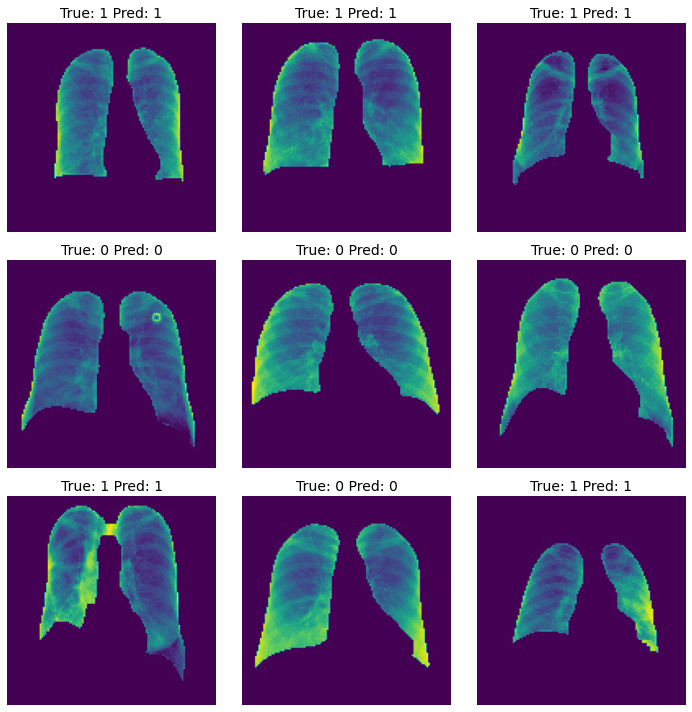

In [18]:
plt.figure(figsize=(10,10))
plt.axis('Off')

start_from = 10

for i in range(1, 10):
    plt.subplot(3,3,i)
    test_image = X_test[i + start_from, :, :, 0]
    plt.imshow((test_image))

    true = df_test.loc[i + start_from, 'type']
    pred = df_test.loc[i + start_from, 'preds']
    result = 'True: ' + str(int(true)) + ' Pred: ' + str(pred)

    plt.title(result, fontsize=14)
    plt.axis('off')


plt.tight_layout()
plt.show()

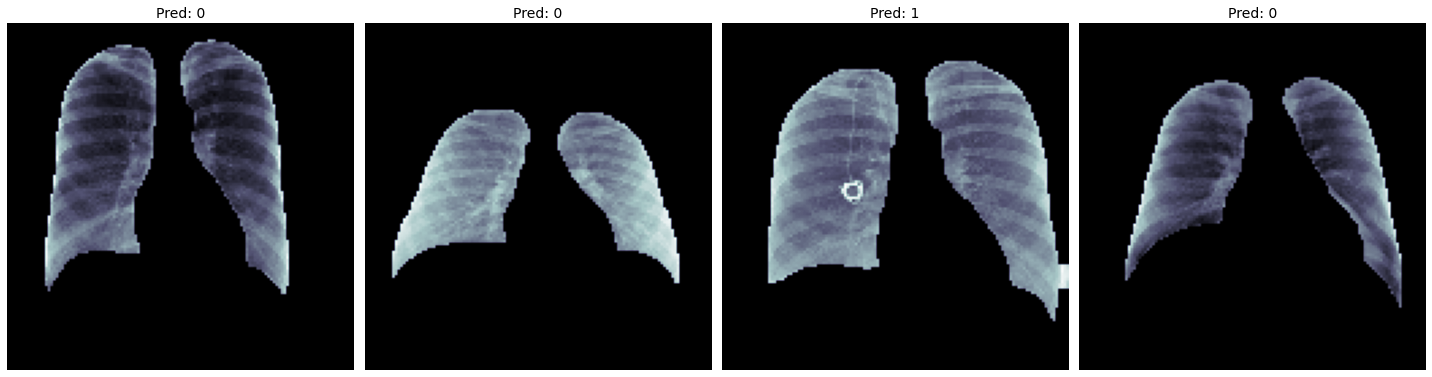

In [129]:
model = load_model(modelName)

img_list = os.listdir("deneme")

mask_model = load_model("model.h5")

img_count = len(img_list)

X_test_priv = np.zeros((img_count + 1, IMG_HEIGHT, IMG_WIDTH, 3))

virtual_index = 0
for img_name in img_list:
    img_file = "deneme\\" + img_name
    
    x = np.zeros((1, IMG_HEIGHT, IMG_WIDTH))
    
    img1 = readImages(img_file, is_gray=0)
    
    x[0] = img1
    
    img = (mask_model.predict(x/255.)*255.0)[0]
    
    img = fillHoles(img)
    img = removeSmallObjects(img, min_area = 200)
    img = cv2.bitwise_and(img1, img1, mask=img.astype(np.uint8))
    
    x[0] = img
    
    x = np.repeat(x[..., np.newaxis], 3, -1)
    x = x.reshape(-1, 128, 128, 3)
    
    X_test_priv[virtual_index] = x[0]
    virtual_index += 1

preds = np.argmax(model.predict(X_test_priv/255.0), axis=-1)

plt.figure(figsize=(20,20))
plt.axis('Off')

for i in range(0, img_count):
    plt.subplot(1, img_count, i + 1)
    test_image = X_test_priv[i]
    plt.imshow(test_image[:,:,0], cmap=plt.cm.bone)
    plt.title(f'Pred: {int(preds[i])}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()